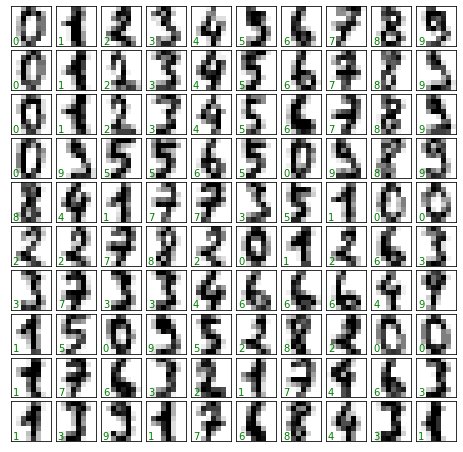

In [1]:
import numpy as np;import pandas as pd;from sklearn.datasets import load_digits;import matplotlib.pyplot as plt


data=load_digits()

fig,ax=plt.subplots(10,10,figsize=(8,8),subplot_kw={'xticks':[],'yticks':[]},gridspec_kw=dict(hspace=0.1,wspace=0.1))

for i, ax in enumerate(ax.flat):
    ax.imshow(data.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(data.target[i]),
    transform=ax.transAxes, color='green')


In [2]:
from sklearn.model_selection import train_test_split
X=data.data
y=data.target
X_train,y_train=X[:1000],y[:1000]
X_test,y_test=X[1000:],y[1000:]


In [7]:
import numpy as np
import sys

class NeuralNetMLP():
 

    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
   
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h

        a_h=self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out

        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]  
        n_features = X_train.shape[1]


        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                sigma_out = a_out - y_train_enc[batch_idx]
                sigmoid_derivative_h = a_h * (1. - a_h)

                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h   
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [8]:
from MLP import MLP
nn = NeuralNetMLP(n_hidden=200,l2=0.1,epochs=300,eta=0.0005,minibatch_size=200,shuffle=True,seed=1)
nn.fit(X_train=X_train,X_valid=X_test,y_train=y_train,y_valid=y_test)


300/300 | Cost: 72.00 | Train/Valid Acc.: 100.00%/94.86%  

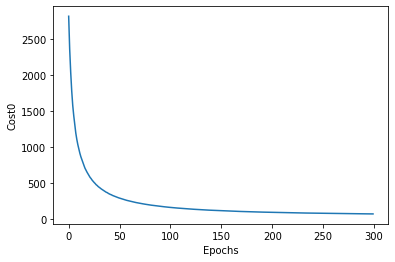

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost0')
plt.xlabel('Epochs')
plt.show()

###### Como se puede observar de la gráfica anterior el costo decrece rápidamente antes de 100 epochs y parece converger despues de las 150.

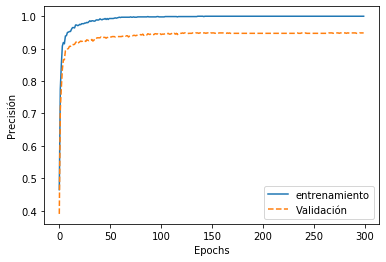

In [10]:
plt.plot(range(nn.epochs),nn.eval_['train_acc'],label='entrenamiento')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'],label='Validación',linestyle='--')
plt.xlabel('Epochs');plt.ylabel('Precisión')
plt.legend()

##### Se observa claramente que amedida el número de epochs aumenta las dos curvas tienden a hacerse paralelas, indicando que no se puede obtener una mejor precisión sobre el conjunto de validación al aumentar el número de epochs.

In [11]:
from sklearn.metrics import accuracy_score

y_pred=nn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9485570890840652


###### De la última gráfica y de el puntaje de validación anterior se puede concluir que le módelo para el conjunto de datos presentado presenta overfitting. Una forma posible de mejorar la predición es aumentar el parámetro de regularización l2.